MSE for Point 1: [1.8407094 2.7033992]
MSE for Point 2: [10.174677 15.432619]
MSE for Point 3: [466.7426    25.353992]
MSE for Point 4: [185.09988 102.78475]
MSE for Point 5: [300.41412 132.04866]
MSE for Point 6: [183.96999 257.0664 ]
Overall Mean Squared Error: 140.30
Predicted 2D Pixel Coordinates: [[698.57336 433.8298 ]
 [725.8125  360.7022 ]
 [771.8556  208.15869]
 [743.2102  209.95857]
 [755.2959  146.70804]
 [811.7265  121.12408]]


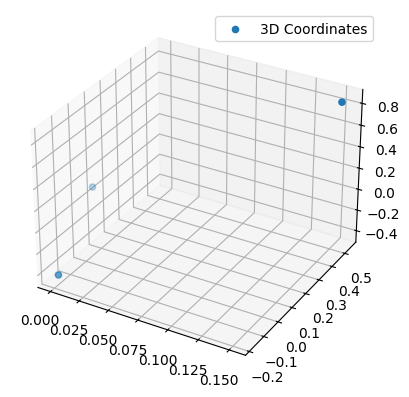

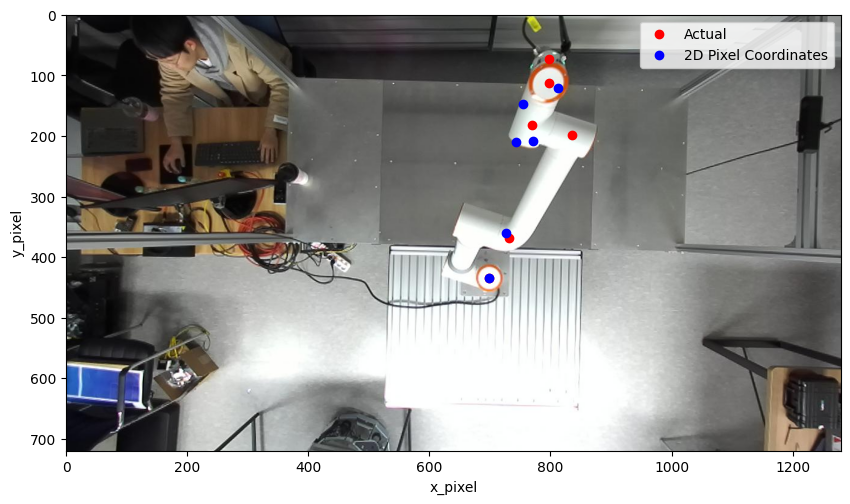

In [29]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import joblib
import json
import matplotlib.pyplot as plt
import cv2

def load_dataset():
    X = []  # 3D 좌표 (입력)
    y = []  # 2D 픽셀 좌표 (출력)

    joint_path = '/home/najo/NAS/DIP/datasets/FR5_model/joint'
    pixel_path = '/home/najo/NAS/DIP/datasets/FR5_model/point_label/image990.json'
    
    with open(pixel_path, 'r') as f:
            pixel = json.load(f)
    
    for file in pixel.keys():
        base_name = file.rstrip(".jpg")
        new_name = f"joint{base_name[5:]}.json"
        with open(os.path.join(joint_path, new_name), 'r') as f:
            joint = json.load(f)
            X.append(joint)  # 3D 좌표 추가
            y.append(pixel[file])  # 2D 좌표 추가

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

def train_model(X, y):
    """
    다중 레이블 회귀 모델을 학습
    """
    # 데이터셋 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    models = []
    # Random Forest Regressor 모델 생성
    # model = MultiOutputRegressor(XGBRegressor(n_estimators=400, learning_rate=0.07, random_state=42, colsample_bytree = 1, max_depth=9))
    # model.fit(X_train, y_train)

    for i in range(6):  # 6개의 다중 출력 모델 생성
        model = MultiOutputRegressor(XGBRegressor(n_estimators=400, learning_rate=0.07, subsample=0.75, colsample_bytree = 1, max_depth=9))
        model.fit(X_train[:, i, :], y_train[:, i, :])  # 각 3D 좌표에 대해 학습
        models.append(model)
    
    # 테스트 데이터에서 예측
    # y_pred = model.predict(X_test)
    # mse = mean_squared_error(y_test, y_pred)
    # print(f"Mean Squared Error on Test Data: {mse}")
    
    # 4. 모델 평가
    mse_per_point = []
    for i, model in enumerate(models):
        y_pred = model.predict(X_test[:, i, :])
        mse = mean_squared_error(y_test[:, i, :], y_pred, multioutput="raw_values")
        mse_per_point.append(mse)
        print(f"MSE for Point {i + 1}: {mse}")

    overall_mse = np.mean(mse_per_point)
    print(f"Overall Mean Squared Error: {overall_mse:.2f}")

    return models

# def save_model(model, output_path):
#     joblib.dump(model, output_path)
#     print(f"Model saved to {output_path}")

# def load_model(model_path):
#     return joblib.load(model_path)

# 실행 예제
if __name__ == "__main__":
    X, y = load_dataset()
    
    X_flat = X.reshape(-1, 6, 3)
    y_flat = y.reshape(-1, 6, 2)
    
    # x_scaler=StandardScaler()
    # x_scaler.fit(X_flat)
    # data_normalized=x_scaler.transform(X_flat)
    
    # y_scaler=StandardScaler()
    # y_scaler.fit(y_flat)
    # y_normalized=y_scaler.transform(y_flat)

    models = train_model(X_flat, y_flat)

    # model_path = "/home/najo/NAS/DIP/datasets/FR5_model/Robot_joint_inference/multi_label_regressor.pkl"
    # save_model(model, model_path)
    # model = load_model(model_path)
    
    joint_path = '/home/najo/NAS/DIP/datasets/FR5_model/joint'
    joint_filename = sorted([f for f in os.listdir(joint_path) if f.endswith('.json')])
    
    with open(os.path.join(joint_path, joint_filename[0]), 'r') as file:
        data = np.array(json.load(file))
    
    new_input = data.reshape(-1, 6, 3)
    predictions = []
    
    for i, model in enumerate(models):
        pred = model.predict(new_input[:, i, :])
        predictions.append(pred)
    
    predictions = np.array(predictions).reshape(6, 2)
    print(f"Predicted 2D Pixel Coordinates: {predictions}")

# 입력 데이터 3D 시각화
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_input[:, 0],new_input[:, 1],new_input[:, 2], label="3D Coordinates")
ax.legend()
plt.show()

# 출력 데이터 2D 시각화

image = cv2.imread("/home/najo/NAS/DIP/datasets/FR5_model/image/image0.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib
y_value = y_flat[0].reshape(6, 2)
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("on")
plt.scatter(y_value[:, 0], y_value[:, 1], color='red', label='Actual')
plt.scatter(predictions[:, 0], predictions[:, 1], color='blue',  label="2D Pixel Coordinates")
plt.xlabel("x_pixel")
plt.ylabel("y_pixel")
plt.legend()
plt.show()


In [11]:
import numpy as np

def augment_data(X, y, num_augmentations=3):
    augmented_X = []
    augmented_y = []
    
    for i in range(X.shape[0]):
        original_X = X[i]
        original_y = y[i]
        
        # 원본 데이터 추가
        augmented_X.append(original_X)
        augmented_y.append(original_y)
        
        for _ in range(num_augmentations):
            # 노이즈 추가
            noise = np.random.normal(0, 0.01, original_X.shape)  # 평균 0, 표준편차 0.01
            noisy_X = original_X + noise
            
            # 축소/확대
            scale = np.random.uniform(0.9, 1.1)  # 90% ~ 110% 크기
            scaled_X = noisy_X * scale
            
            # 회전
            angle = np.random.uniform(-15, 15)  # -15도 ~ 15도
            rotated_X = rotate_3d(scaled_X, angle, axis='z')  # z축 기준 회전
            
            # 반전
            flipped_X = rotated_X * np.random.choice([-1, 1], size=rotated_X.shape)
            
            # 증강 데이터 추가
            augmented_X.append(flipped_X)
            augmented_y.append(original_y)  # 출력은 동일
            
    return np.array(augmented_X), np.array(augmented_y)

def rotate_3d(points, angle, axis='z'):
    angle_rad = np.radians(angle)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    
    if axis == 'x':
        rotation_matrix = np.array([
            [1, 0, 0],
            [0, cos_a, -sin_a],
            [0, sin_a, cos_a]
        ])
    elif axis == 'y':
        rotation_matrix = np.array([
            [cos_a, 0, sin_a],
            [0, 1, 0],
            [-sin_a, 0, cos_a]
        ])
    elif axis == 'z':
        rotation_matrix = np.array([
            [cos_a, -sin_a, 0],
            [sin_a, cos_a, 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError("Invalid axis, choose from 'x', 'y', 'z'")
    
    rotated_points = np.dot(points, rotation_matrix.T)
    return rotated_points


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# DNN 모델 정의
class ResidualDNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(ResidualDNN, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)  # 입력 차원을 숨김 차원으로 변환
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 입력 차원을 변환하여 Residual Connection에 맞춤
        residual = self.input_proj(x)
        x = torch.relu(self.fc1(residual))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x) + residual)  # Residual Connection
        return self.fc_out(x)

X, y = load_dataset()
# X_augmented, y_augmented = augment_data(X, y, num_augmentations=5)

X_augmented = torch.tensor(X.reshape(-1, 18), dtype=torch.float32).to(device)
y_augmented = torch.tensor(y.reshape(-1, 12), dtype=torch.float32).to(device)

# 학습 데이터셋 준비

dataset = TensorDataset(X_augmented, y_augmented)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

# 모델 초기화
input_dim = 18
output_dim = 12

model = ResidualDNN(18, 12).to(device)

# 손실 함수 및 옵티마이저
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=300, gamma=0.5)

# 학습
epochs = 3000
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in dataloader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Using device: cuda
Epoch [100/3000], Loss: 63.4712
Epoch [200/3000], Loss: 54.4174
Epoch [300/3000], Loss: 57.4526
Epoch [400/3000], Loss: 58.6943
Epoch [500/3000], Loss: 58.9948
Epoch [600/3000], Loss: 32.9416
Epoch [700/3000], Loss: 31.3921
Epoch [800/3000], Loss: 31.7092
Epoch [900/3000], Loss: 30.1560
Epoch [1000/3000], Loss: 25.6574
Epoch [1100/3000], Loss: 24.3872
Epoch [1200/3000], Loss: 27.2929
Epoch [1300/3000], Loss: 22.4762
Epoch [1400/3000], Loss: 28.0066
Epoch [1500/3000], Loss: 24.5628
Epoch [1600/3000], Loss: 25.3049
Epoch [1700/3000], Loss: 18.2613
Epoch [1800/3000], Loss: 21.1936
Epoch [1900/3000], Loss: 24.2562
Epoch [2000/3000], Loss: 19.4539
Epoch [2100/3000], Loss: 22.7493
Epoch [2200/3000], Loss: 19.0220
Epoch [2300/3000], Loss: 23.1126
Epoch [2400/3000], Loss: 21.6944
Epoch [2500/3000], Loss: 23.1147
Epoch [2600/3000], Loss: 21.6484
Epoch [2700/3000], Loss: 19.7687
Epoch [2800/3000], Loss: 19.8072
Epoch [2900/3000], Loss: 19.5497
Epoch [3000/3000], Loss: 21.9939


In [26]:
# 예측
model.eval()
with torch.no_grad():
    with open(os.path.join(joint_path, joint_filename[0]), 'r') as file:
        data = np.array(json.load(file))
    
    new_input = data.reshape(-1, 18)
    test_input = torch.tensor(new_input, dtype=torch.float32).to(device)

    test_output = model(test_input)
    print("Compare Input")
    print(X_augmented[0].cpu().reshape(6, 3))
    print("real Input")
    print(test_input.cpu().reshape(6, 3))
    print("Predicted Output:")
    print(test_output.view(-1, 2))  # 6 x 2로 출력
    print("label Output:")
    print(y_augmented[1].cpu().reshape(6, 2))

Compare Input
tensor([[ 0.0000,  0.0000,  0.1520],
        [-0.1732,  0.0544,  0.5363],
        [-0.4204,  0.1321,  0.8344],
        [-0.4510,  0.0348,  0.8344],
        [-0.5252,  0.0581,  0.9003],
        [-0.5869,  0.0775,  0.8240]])
real Input
tensor([[ 0.0000,  0.0000,  0.1520],
        [-0.1732,  0.0544,  0.5363],
        [-0.4204,  0.1321,  0.8344],
        [-0.4510,  0.0348,  0.8344],
        [-0.5252,  0.0581,  0.9003],
        [-0.5869,  0.0775,  0.8240]])
Predicted Output:
tensor([[700.5247, 436.4221],
        [762.5175, 365.7850],
        [823.6677, 197.4252],
        [778.6891, 182.1133],
        [797.3336, 128.6229],
        [791.2603, 148.1942]], device='cuda:0')
label Output:
tensor([[699., 435.],
        [743., 357.],
        [851., 176.],
        [791., 157.],
        [820.,  88.],
        [820.,  79.]])


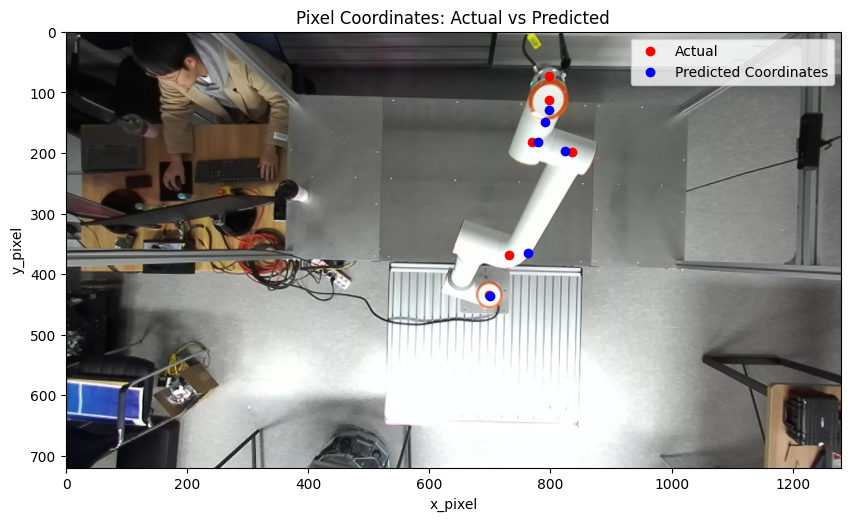

In [27]:
image = cv2.imread("/home/najo/NAS/DIP/datasets/FR5_model/image/image0.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib
test_output = test_output.cpu().reshape(6, 2)
new_input = y_augmented[0].cpu().reshape(6, 2)
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("on")
plt.scatter(new_input[:, 0], new_input[:, 1], color='red', label='Actual')
plt.scatter(test_output[:, 0], test_output[:, 1], color='blue', label="Predicted Coordinates")
plt.xlabel("x_pixel")
plt.ylabel("y_pixel")
plt.legend()
plt.title("Pixel Coordinates: Actual vs Predicted")
plt.show()